# Electronic Parts Country of Origin Prediction

Simple demo using BGE-Large embeddings via vLLM and KNN classification.

## 1. Setup and Configuration

In [3]:
!pip install openai
!pip install seaborn


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [20]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import sys
# from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
# load_dotenv()
sys.path.append('../utils/')
from vllm_client import create_vllm_client, get_embeddings

In [21]:
# Configuration - your vLLM details are set via environment variables
# These are automatically configured by the workbench deployment

ENDPOINT = os.getenv('ENDPOINT')
EMBEDDING_MODEL = os.getenv('EMBEDDING_MODEL')
API_KEY = os.getenv('API_KEY')

print(f"Endpoint: {ENDPOINT}")
print(f"Model: {EMBEDDING_MODEL}")
print(f"API Key: {'[CONFIGURED]' if API_KEY else '[MISSING - set in deployment]'}")

Endpoint: https://bge-large-arrow-embedding.apps.cluster-5qlcr.5qlcr.sandbox1342.opentlc.com
Model: bge-large
API Key: [CONFIGURED]


## 2. Load Data

In [23]:
# Load the synthetic electronics data

df = pd.read_csv('../data/synthetic_electronics_parts_1k.csv')

df.head(10)

,Part_Description,Country_Of_Origin
0,A industrial standard resistor for standard ap...,China
1,Manufactured for standard needs: PCB with thro...,China
2,"high-bandwidth OLED panel, compact design.gree...",South Korea
3,"precision-engineered sensor (industrial), cert...",Germany
4,A certified relay (industrial) for precision-e...,Germany
5,processor (advanced) with high-resolution feat...,South Korea
6,"mass-produced LED, industrial standard.green SMD.",China
7,A AI-enabled display panel components for inte...,Taiwan
8,"innovative power management IC, compact.voltag...",Taiwan
9,A component-level sensor assembly for discrete...,Malaysia


## 3. Connect to vLLM and Generate Embeddings

In [24]:
# Create vLLM client
client = create_vllm_client(ENDPOINT, EMBEDDING_MODEL, API_KEY)

In [25]:
# Generate embeddings for part descriptions
descriptions = df['Part_Description'].tolist()
print(f"🔄 Generating embeddings for {len(descriptions)} descriptions...")

embeddings = get_embeddings(client, descriptions, EMBEDDING_MODEL)

if embeddings:
    X = np.array(embeddings)
    print(f"✅ Generated embeddings with shape: {X.shape}")
    print(f"   - Embedding dimension: {X.shape[1]}")
else:
    print("❌ Failed to generate embeddings")
    print("Check your vLLM endpoint and API key configuration")

🔄 Generating embeddings for 1000 descriptions...
✅ Generated embeddings with shape: (1000, 1024)
   - Embedding dimension: 1024


## 4. Train KNN Classifier

In [26]:
# Prepare labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Country_Of_Origin'])
class_names = label_encoder.classes_

print(f"📊 Dataset info:")
print(f"   - Total samples: {len(X)}")
print(f"   - Number of countries: {len(class_names)}")
print(f"   - Countries: {list(class_names)}")

📊 Dataset info:
   - Total samples: 1000
   - Number of countries: 8
   - Countries: ['China', 'Germany', 'Japan', 'Malaysia', 'South Korea', 'Taiwan', 'USA', 'Vietnam']


In [27]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Split data: {len(X_train)} train, {len(X_test)} test")


Split data: 800 train, 200 test


In [28]:
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
print(f"🤖 Training KNN classifier")
knn.fit(X_train, y_train)
print("✅ KNN training complete")

🤖 Training KNN classifier
✅ KNN training complete


## 5. Evaluate Model

In [29]:
# Make predictions
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"🎯 Model Performance:")
print(f"   - Accuracy: {accuracy:.1%}")

🎯 Model Performance:
   - Accuracy: 95.0%


In [30]:
# Show detailed results
print("\n📊 Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


📊 Detailed Classification Report:
              precision    recall  f1-score   support

       China       1.00      0.83      0.91        24
     Germany       0.89      1.00      0.94        25
       Japan       1.00      1.00      1.00        26
    Malaysia       0.85      1.00      0.92        23
 South Korea       1.00      1.00      1.00        27
      Taiwan       0.96      0.93      0.95        28
         USA       0.91      0.83      0.87        24
     Vietnam       1.00      1.00      1.00        23

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



## 6. Visualize Results

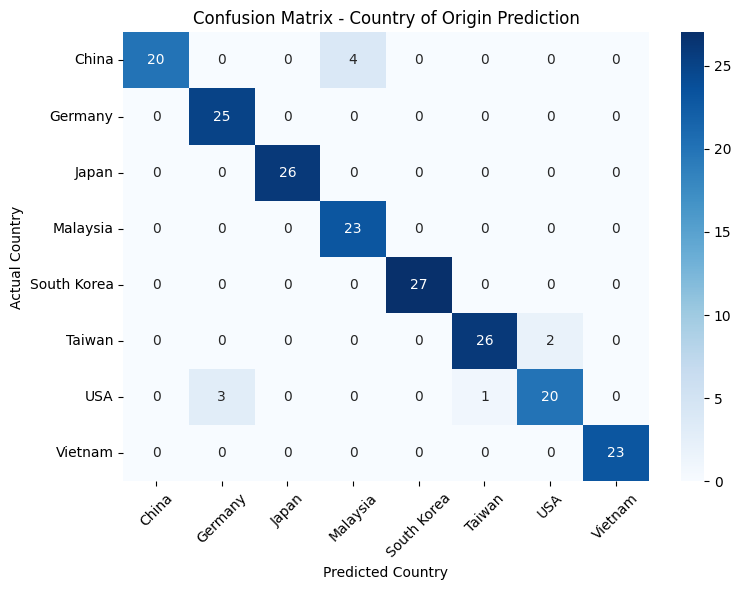

In [31]:
# Create confusion matrix
if len(class_names) > 1:
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Country of Origin Prediction')
    plt.xlabel('Predicted Country')
    plt.ylabel('Actual Country')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping confusion matrix (only one class)")

In [32]:
# Show sample predictions
print("\n🔍 Sample Predictions:")
print("=" * 80)

for i in range(min(len(X_test), 5)):
    desc = descriptions[i] if i < len(descriptions) else "Sample description"
    actual = class_names[y_test[i]]
    predicted = class_names[y_pred[i]]
    
    print(f"\nSample {i+1}:")
    print(f"Description: {desc[:100]}{'...' if len(desc) > 100 else ''}")
    print(f"Actual: {actual}")
    print(f"Predicted: {predicted}")
    print(f"Result: {'✅ Correct' if actual == predicted else '❌ Incorrect'}")


🔍 Sample Predictions:

Sample 1:
Description: A industrial standard resistor for standard applications.220 ohm 0.1% tolerance, 0603.
Actual: Vietnam
Predicted: Vietnam
Result: ✅ Correct

Sample 2:
Description: Manufactured for standard needs: PCB with through-hole.
Actual: Malaysia
Predicted: Malaysia
Result: ✅ Correct

Sample 3:
Description: high-bandwidth OLED panel, compact design.green 0805.
Actual: China
Predicted: China
Result: ✅ Correct

Sample 4:
Description: precision-engineered sensor (industrial), certified.pressure analog output.
Actual: South Korea
Predicted: South Korea
Result: ✅ Correct

Sample 5:
Description: A certified relay (industrial) for precision-engineered applications.
Actual: USA
Predicted: USA
Result: ✅ Correct


## 7. Test with New Examples

In [33]:
# Test with new part descriptions
test_descriptions = [
    "high-frequency RF transistor for mobile communication systems",
    "robust power MOSFET for electric vehicle inverters",
    "miniature MEMS accelerometer for wearable fitness trackers",
    "radiation-hardened FPGA for aerospace applications",
    "multi-layer ceramic inductor for high-efficiency DC-DC converters",
    "ultra-low-power Bluetooth SoC for IoT smart home devices",
    "thermally stable voltage regulator for telecom base stations",
    "automated LiDAR module for autonomous delivery drones",
    "waterproof piezoelectric buzzer for marine instrumentation",
    "energy-harvesting rectifier circuit for remote sensors"
]

print("🧪 Testing with new examples:")
print("=" * 50)

# Generate embeddings for test descriptions
test_embeddings = get_embeddings(client, test_descriptions, EMBEDDING_MODEL)

if test_embeddings:
    test_X = np.array(test_embeddings)
    test_predictions = knn.predict(test_X)
    test_probabilities = knn.predict_proba(test_X)
    
    for i, desc in enumerate(test_descriptions):
        predicted_country = class_names[test_predictions[i]]
        confidence = test_probabilities[i].max()
        
        print(f"\nTest {i+1}: {desc}")
        print(f"Predicted Country: {predicted_country}")
        print(f"Confidence: {confidence:.2f}")
else:
    print("❌ Failed to generate embeddings for test examples")

🧪 Testing with new examples:

Test 1: high-frequency RF transistor for mobile communication systems
Predicted Country: USA
Confidence: 1.00

Test 2: robust power MOSFET for electric vehicle inverters
Predicted Country: Germany
Confidence: 1.00

Test 3: miniature MEMS accelerometer for wearable fitness trackers
Predicted Country: Germany
Confidence: 0.33

Test 4: radiation-hardened FPGA for aerospace applications
Predicted Country: USA
Confidence: 1.00

Test 5: multi-layer ceramic inductor for high-efficiency DC-DC converters
Predicted Country: Japan
Confidence: 1.00

Test 6: ultra-low-power Bluetooth SoC for IoT smart home devices
Predicted Country: Taiwan
Confidence: 1.00

Test 7: thermally stable voltage regulator for telecom base stations
Predicted Country: Taiwan
Confidence: 0.67

Test 8: automated LiDAR module for autonomous delivery drones
Predicted Country: Japan
Confidence: 1.00

Test 9: waterproof piezoelectric buzzer for marine instrumentation
Predicted Country: Germany
Confi

## Summary

🎉 **Demo Complete!**

This notebook demonstrates:
- ✅ BGE-Large embeddings via vLLM API
- ✅ KNN classification for country prediction
- ✅ Model evaluation and visualization
- ✅ Real-time inference with new examples

The model uses semantic embeddings from transformer models to understand the relationship between part descriptions and their likely countries of origin.